# CIV1504: BikeShare Toronto
## Part 2: Analysis and Experiments
---
**Author:** Nicole Chan<br> 
**Start Date:** Nov 17th, 2023<br>
**End Date:** Dec 10th, 2023<br>

## Introduction

This Jupyter Notebook is Part 2 of my CIV1504 Project. In part 1, I cleaned and merged the data of BikeShare Toronto data set and hourly weather data gathered from Environment Canada, between the dates of 2018-01-01 to 2020-12-31.

Below you will find several pplication of course concepts: Correlation Analysis, ANOVA, Linear Regression, Ordinary Least Square and Maximun Likelihood estimate (MLE)



In [53]:
#read files from Part1 Notebook
%store -r weather_type_df
%store -r df18_20
%store -r data_hours
%store -r data_days

In [54]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [55]:
df18_20.columns

Index(['Trip Id', 'Start Time', 'Start Station Id', 'Start Station Name',
       'End Time', 'End Station Id', 'End Station Name',
       'Trip Duration (Seconds)', 'Member', 'Weekend', 'Holiday', 'Temp (°C)',
       'Dew Point Temp (°C)', 'Rel Hum (%)', 'Visibility (km)',
       'Stn Press (kPa)', 'Hmdx', 'Wind Chill', 'Clear', 'Strong Wind',
       'Blowing Snow', 'Fog', 'Freezing Rain', 'Haze', 'Heavy Rain',
       'Heavy Snow', 'Moderate Rain', 'Moderate Snow', 'Rain', 'Snow',
       'Thunderstorms', 'Weather_Type'],
      dtype='object')

### Simplify weather type into 3 main groups: rain, clear and snow for correlation matrix 
- clear: 'Strong Wind','Fog','Haze'
- rain: 'Thunderstorms','Heavy Rain','Moderate Rain','Rain'
- snow: 'Moderate Snow','Snow', 'Freezing Rain','Heavy Snow'

In [56]:
df18_20_simplified=df18_20.copy()
df18_20_simplified['clear']=df18_20.Clear + df18_20.Fog + df18_20.Haze
df18_20_simplified['snow']=df18_20['Moderate Snow'] + df18_20.Snow + df18_20['Freezing Rain']+df18_20['Heavy Snow']+df18_20['Blowing Snow']
df18_20_simplified['rain']=df18_20['Thunderstorms'] + df18_20['Heavy Rain']+df18_20['Moderate Rain']+df18_20['Rain']

In [57]:
columns_to_drop = ['Trip Id','Start Station Id','Start Station Name','End Time','End Station Id','End Station Name','Strong Wind', 'Fog', 'Haze', 'Thunderstorms', 'Heavy Rain', 'Moderate Rain', 'Rain',
                   'Moderate Snow', 'Snow', 'Freezing Rain', 'Heavy Snow', 'Blowing Snow', "Weather_Type","Clear"]
df18_20_simplified = df18_20_simplified.drop(columns=columns_to_drop)


In [58]:
df18_20_simplified[df18_20_simplified.snow == 1]

,Start Time,Trip Duration (Seconds),Member,Weekend,Holiday,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,clear,snow,rain
128,2018-01-01 14:31:00,110,1,0,1,-8.9,-12.7,74.0,4.8,101.62,0.0,-17.0,0.0,1.0,0.0
129,2018-01-01 14:32:00,571,1,0,1,-8.9,-12.7,74.0,4.8,101.62,0.0,-17.0,0.0,1.0,0.0
130,2018-01-01 14:32:00,566,1,0,1,-8.9,-12.7,74.0,4.8,101.62,0.0,-17.0,0.0,1.0,0.0
131,2018-01-01 14:42:00,429,1,0,1,-8.9,-12.7,74.0,4.8,101.62,0.0,-17.0,0.0,1.0,0.0
132,2018-01-01 14:56:00,818,1,0,1,-8.9,-12.7,74.0,4.8,101.62,0.0,-17.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7267729,2020-12-31 10:26:00,541,0,0,0,0.8,-5.0,65.0,16.1,101.31,0.0,0.0,0.0,1.0,1.0
7267730,2020-12-31 10:26:00,1005,1,0,0,0.8,-5.0,65.0,16.1,101.31,0.0,0.0,0.0,1.0,1.0
7267731,2020-12-31 10:27:00,352,1,0,0,0.8,-5.0,65.0,16.1,101.31,0.0,0.0,0.0,1.0,1.0
7267732,2020-12-31 10:28:00,134,1,0,0,0.8,-5.0,65.0,16.1,101.31,0.0,0.0,0.0,1.0,1.0


In [59]:
#aggregate weather types based on the # of occurrences within a day
df_18_20_days = df18_20_simplified.groupby(df18_20_simplified['Start Time'].dt.floor('D')).agg(
    rides=('Member', 'count'),
    annual_members=('Member', lambda x: (x == 1).sum()),
    casual_members=('Member', lambda x: (x == 0).sum()),
    max_temp=('Temp (°C)', max),
    min_temp=('Temp (°C)', min),
    dew_pt_max=('Dew Point Temp (°C)',max),
    dew_pt_min=('Dew Point Temp (°C)',min),
    max_rel_hum=('Rel Hum (%)',max),
    min_visbility=('Visibility (km)',min),
    min_wind_chill=('Wind Chill',min)
)

daily_weather_counts = df18_20_simplified.set_index("Start Time")
daily_weather_counts = daily_weather_counts[["clear", "snow", "rain"]].resample('D').sum()
final_weather_type = daily_weather_counts["clear"].copy()
for i in range(daily_weather_counts.shape[0]):
    final_weather = "clear"
    if daily_weather_counts.iloc[i]["snow"] > daily_weather_counts.iloc[i]["rain"]:
        final_weather = "snow"
    elif daily_weather_counts.iloc[i]["snow"] < daily_weather_counts.iloc[i]["rain"]:
        final_weather = "rain"
    elif daily_weather_counts.iloc[i]["snow"] != 0:
        # Snow and rain are equal and nonzero
        final_weather = "snow"
    final_weather_type.iloc[i] = final_weather

df_18_20_days["weather_type"] = final_weather_type
df_18_20_days = pd.get_dummies(df_18_20_days, columns=["weather_type"])
df_18_20_days.head()

,rides,annual_members,casual_members,max_temp,min_temp,dew_pt_max,dew_pt_min,max_rel_hum,min_visbility,min_wind_chill,weather_type_clear,weather_type_rain,weather_type_snow
Start Time,,,,,,,,,,,,,
2018-01-01,243,235,8,-8.0,-17.9,-12.7,-21.6,78.0,4.8,-26.0,False,False,True
2018-01-02,954,935,19,-6.6,-13.3,-11.2,-17.2,80.0,3.2,-21.0,False,False,True
2018-01-03,1181,1166,15,-5.0,-10.1,-9.0,-17.8,77.0,4.8,-21.0,False,False,True
2018-01-04,1170,1154,16,-7.6,-18.7,-11.4,-24.9,77.0,16.1,-31.0,False,False,True
2018-01-05,783,773,10,-15.2,-20.4,-20.2,-26.0,66.0,11.3,-31.0,False,False,True


In [60]:
# Instantiate Ontario Holidays
import holidays
from datetime import date
ont_holidays = holidays.CA(years=[2018,2019,2020])
df_18_20_days['Holiday'] = df_18_20_days.index.to_series().isin(ont_holidays).astype(int)
df_18_20_days['Weekend'] = ((df_18_20_days.index.dayofweek) > 5).astype(int)

In [61]:
df_18_20_days

,rides,annual_members,casual_members,max_temp,min_temp,dew_pt_max,dew_pt_min,max_rel_hum,min_visbility,min_wind_chill,weather_type_clear,weather_type_rain,weather_type_snow,Holiday,Weekend
Start Time,,,,,,,,,,,,,,,
2018-01-01,243,235,8,-8.0,-17.9,-12.7,-21.6,78.0,4.8,-26.0,False,False,True,1,0
2018-01-02,954,935,19,-6.6,-13.3,-11.2,-17.2,80.0,3.2,-21.0,False,False,True,0,0
2018-01-03,1181,1166,15,-5.0,-10.1,-9.0,-17.8,77.0,4.8,-21.0,False,False,True,0,0
2018-01-04,1170,1154,16,-7.6,-18.7,-11.4,-24.9,77.0,16.1,-31.0,False,False,True,0,0
2018-01-05,783,773,10,-15.2,-20.4,-20.2,-26.0,66.0,11.3,-31.0,False,False,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1558,1189,369,2.8,-2.3,0.7,-6.0,86.0,16.1,-10.0,False,True,False,0,1
2020-12-28,2097,1573,524,5.1,-1.4,3.7,-7.4,92.0,16.1,-7.0,False,True,False,0,0
2020-12-29,2767,2075,692,-0.5,-3.7,-7.2,-10.1,74.0,16.1,-10.0,False,False,True,0,0


In [62]:
print(df_18_20_days.columns)

Index(['rides', 'annual_members', 'casual_members', 'max_temp', 'min_temp',
       'dew_pt_max', 'dew_pt_min', 'max_rel_hum', 'min_visbility',
       'min_wind_chill', 'weather_type_clear', 'weather_type_rain',
       'weather_type_snow', 'Holiday', 'Weekend'],
      dtype='object')


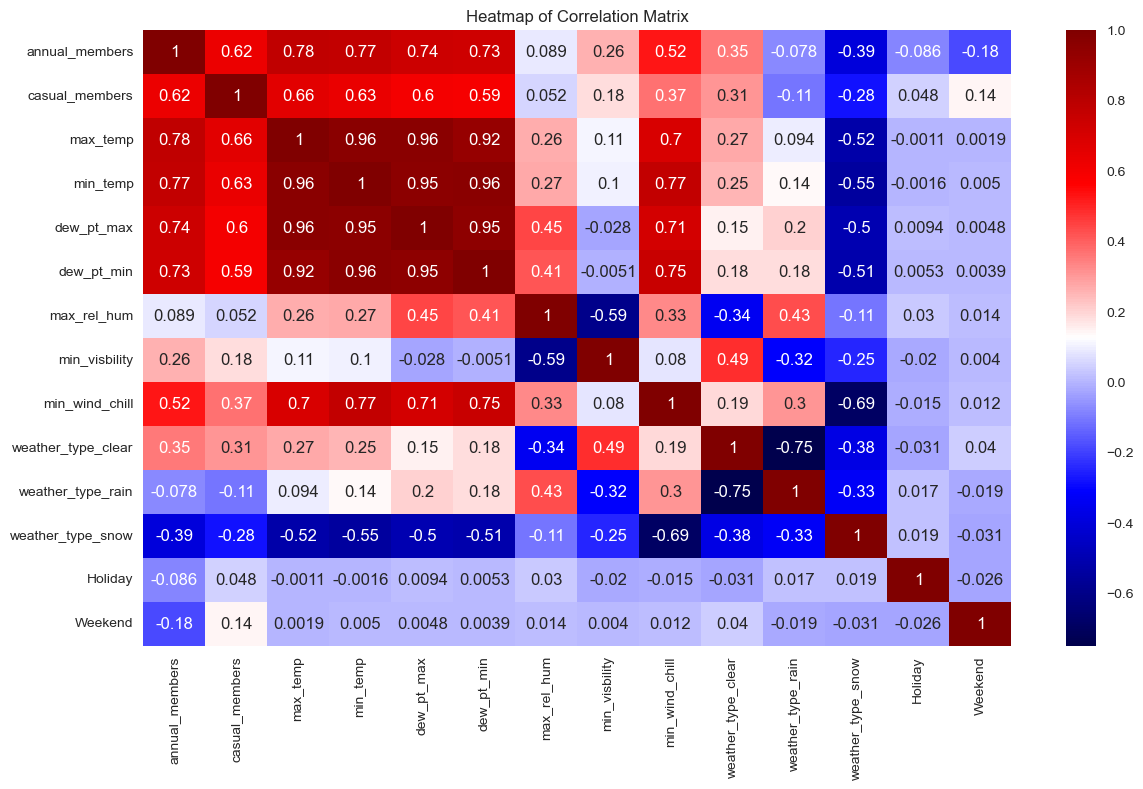

In [63]:
def plot_correlation_matrix(input_df: pd.DataFrame) -> None:
    """
    Plot the correlation matrix of a dataframe, helps in detecting 
    the most prevalent features to preserve
    Input: 
        input_df: the input dataframe. It's suggested to contain the column "customer_attrition"
    """
    fig = plt.figure(figsize=(14,8))
    corr = input_df.corr()
    
    # Use seaborn to plot the heatmap with seismic color scheme, and set x and y labels
    sns.heatmap(corr, annot=True, cmap='seismic',
                      xticklabels=corr.columns.values,
                      yticklabels=corr.columns.values)
    plt.title('Heatmap of Correlation Matrix')
    
correlation_columns = ['annual_members', 'casual_members', 'max_temp', 'min_temp',
       'dew_pt_max', 'dew_pt_min', 'max_rel_hum', 'min_visbility',
       'min_wind_chill', 'weather_type_clear', 'weather_type_rain',
       'weather_type_snow', 'Holiday', 'Weekend']
plot_correlation_matrix(df_18_20_days[correlation_columns])
#plot_correlation_matrix(data_days[correlation_columns2])

### Observation
From correlation matrix, there is clear correlation for max_temp, min_temp, dew_pt_max and dew_pt_min on both annual and casual members, followed by min_wind_chill, weather_type (clear, snow and rain). Rain has the least effect among the 3, and in general, annual members have less correlation in weather_type and more correlation in temp. 

The information will be used to construct the multi-linear regression now.


### 1) Effect of Temperature on Ridership<br>
**How**: Correlation Analysis<br>

**Hypothesis**<br>
**Null Hypothesis (H0):** There is no significant correlation between temperature and ridership numbers.

**Alternative Hypothesis (H1):** Changes in temperature significantly impact ridership numbers.

**Procedure**

1. Compute the Pearson correlation coefficient, denoted as *r*, between temperature and ridership numbers for annual and casual members.
2. Use the `scipy.stats.pearsonr` function to get both the correlation coefficient and its p-value.
3. Assess significance and interpret the result with alpha=0.05.

In [64]:
correlation, p_value = pearsonr(data_days['temperature'], data_days['rides'])

print("Correlation:", correlation)
print("P-value:", p_value)



Correlation: 0.8066961877262343
P-value: 3.6735344765210966e-252


P-value is less than 5%, reject null hypothesis:(no correlation)

### 2) 1-Way and 2-Way ANOVA on Annual and Casual Members

### Hypothesis
**Null Hypothesis (H0):** There is no significant difference in consumer behavior between Annual Members and Casual Members in weather_type, and .

**Alternative Hypothesis (H1):** Annual Members and Casual Members exhibit significantly different behaviors in terms of ride duration, and/or preferred time of day.

### Procedure
1. Use SciPy to perform the 2-way ANOVA.
2. Obtain F-stats, p-values from Step 1.
3. Interpret the result with alpha=0.05.


In [65]:
#examine the values for weather_type
# Examine unique values for weather_type_clear
unique_values_clear = df_18_20_days['weather_type_clear'].unique()
print("Unique values for 'weather_type_clear':", unique_values_clear)

# Examine unique values for weather_type_snow
unique_values_snow = df_18_20_days['weather_type_snow'].unique()
print("Unique values for 'weather_type_snow':", unique_values_snow)

# Examine unique values for weather_type_rain
unique_values_rain = df_18_20_days['weather_type_rain'].unique()
print("Unique values for 'weather_type_rain':", unique_values_rain)


Unique values for 'weather_type_clear': [False  True]
Unique values for 'weather_type_snow': [ True False]
Unique values for 'weather_type_rain': [False  True]


In [66]:
from statsmodels.formula.api import ols

# Perform 2-way ANOVA for annual members
formula_annual = 'annual_members ~ C(weather_type_clear.astype("category")) + C(weather_type_snow.astype("category")) + C(weather_type_rain.astype("category")) + C(Holiday.astype("category")) + C(Weekend.astype("category"))'
model_annual = ols(formula_annual, data=df_18_20_days).fit()
anova_table_annual = anova_lm(model_annual, typ=2)

# Perform 2-way ANOVA for casual members
formula_casual = 'casual_members ~ C(weather_type_clear.astype("category")) + C(weather_type_snow.astype("category")) + C(weather_type_rain.astype("category")) + C(Holiday.astype("category")) + C(Weekend.astype("category"))'
model_casual = ols(formula_casual, data=df_18_20_days).fit()
anova_table_casual = anova_lm(model_casual, typ=2)

# Print ANOVA tables
print("ANOVA Table for Annual Members:")
print(anova_table_annual)

print("\nANOVA Table for Casual Members:")
print(anova_table_casual)


ANOVA Table for Annual Members:
                                                sum_sq      df           F  \
C(weather_type_clear.astype("category"))  4.835360e+09     1.0  797.958451   
C(weather_type_snow.astype("category"))   2.721115e+08     1.0   44.905375   
C(weather_type_rain.astype("category"))   1.179413e+09     1.0  194.633365   
C(Holiday.astype("category"))             5.363851e+07     1.0    8.851731   
C(Weekend.astype("category"))             3.664010e+08     1.0   60.465561   
Residual                                  6.611093e+09  1091.0         NaN   

                                                 PR(>F)  
C(weather_type_clear.astype("category"))  3.338773e-132  
C(weather_type_snow.astype("category"))    3.307783e-11  
C(weather_type_rain.astype("category"))    7.955787e-41  
C(Holiday.astype("category"))              2.992594e-03  
C(Weekend.astype("category"))              1.725482e-14  
Residual                                            NaN  

ANOVA Table fo

In [67]:
# Interpretation
alpha = 0.05
for factor in ['weather_type_clear', 'weather_type_snow', 'weather_type_rain', 'Holiday', 'Weekend']:
    try:
        p_value_annual = anova_table_annual.loc[f'C({factor}.astype("category"))', 'PR(>F)']
        p_value_casual = anova_table_casual.loc[f'C({factor}.astype("category"))', 'PR(>F)']

        print(f"\nFactor: {factor}")
        print(f"P-value for Annual Members: {p_value_annual}")
        print(f"P-value for Casual Members: {p_value_casual}")

        if p_value_annual < alpha:
            print("There is a significant effect on annual members.")
        else:
            print("There is no significant effect on annual members.")

        if p_value_casual < alpha:
            print("There is a significant effect on casual members.")
        else:
            print("There is no significant effect on casual members.")
        
    except KeyError:
        print(f"KeyError: '{factor}' not found in ANOVA table.")



Factor: weather_type_clear
P-value for Annual Members: 3.338773219162734e-132
P-value for Casual Members: 4.559020577538931e-55
There is a significant effect on annual members.
There is a significant effect on casual members.

Factor: weather_type_snow
P-value for Annual Members: 3.3077830711762536e-11
P-value for Casual Members: 1.374798452361508e-11
There is a significant effect on annual members.
There is a significant effect on casual members.

Factor: weather_type_rain
P-value for Annual Members: 7.955786717807117e-41
P-value for Casual Members: 6.2484929298792e-05
There is a significant effect on annual members.
There is a significant effect on casual members.

Factor: Holiday
P-value for Annual Members: 0.002992593906691001
P-value for Casual Members: 0.02706308074654816
There is a significant effect on annual members.
There is a significant effect on casual members.

Factor: Weekend
P-value for Annual Members: 1.725482108103873e-14
P-value for Casual Members: 6.616555432972642

In [68]:
# Perform one-way ANOVA for annual members with only weather type 
model_annual_weather = ols('annual_members ~ C(weather_type_clear) + C(weather_type_snow) + C(weather_type_rain)', data=df_18_20_days).fit()
anova_table_annual_weather = anova_lm(model_annual_weather, typ=2)

# Perform one-way ANOVA for casual members with only weather type 
model_casual_weather = ols('casual_members ~ C(weather_type_clear) + C(weather_type_snow) + C(weather_type_rain)', data=df_18_20_days).fit()
anova_table_casual_weather = anova_lm(model_casual_weather, typ=2)

# Print ANOVA tables
print("ANOVA Table for Annual Members:")
print(anova_table_annual_weather)

print("\nANOVA Table for Casual Members:")
print(anova_table_casual_weather)

# Interpretation
for weather_type in ['weather_type_clear', 'weather_type_snow', 'weather_type_rain']:
    p_value_annual_weather = anova_table_annual_weather.loc[f'C({weather_type})', 'PR(>F)']
    p_value_casual_weather = anova_table_casual_weather.loc[f'C({weather_type})', 'PR(>F)']

    print(f"\nWeather Type: {weather_type}")
    print(f"P-value for Annual Members: {p_value_annual_weather}")
    print(f"P-value for Casual Members: {p_value_casual_weather}")

    if p_value_annual_weather < alpha:
        print("There is a significant effect of weather type on annual members.")
    else:
        print("There is no significant effect of weather type on annual members.")

    if p_value_casual_weather < alpha:
        print("There is a significant effect of weather type on casual members.")
    else:
        print("There is no significant effect of weather type on casual members.")


ANOVA Table for Annual Members:
                             sum_sq      df           F         PR(>F)
C(weather_type_clear)  4.600139e+09     1.0  715.763387  1.071571e-121
C(weather_type_snow)   2.928351e+08     1.0   45.563982   2.392945e-11
C(weather_type_rain)   1.086121e+09     1.0  168.996073   4.946664e-36
Residual               7.024600e+09  1093.0         NaN            NaN

ANOVA Table for Casual Members:
                             sum_sq      df           F        PR(>F)
C(weather_type_clear)  1.094064e+09     1.0  289.206205  1.008299e-57
C(weather_type_snow)   1.653244e+08     1.0   43.702053  5.966522e-11
C(weather_type_rain)   7.151526e+07     1.0   18.904429  1.502596e-05
Residual               4.134808e+09  1093.0         NaN           NaN

Weather Type: weather_type_clear
P-value for Annual Members: 1.0715706284360349e-121
P-value for Casual Members: 1.008299323389023e-57
There is a significant effect of weather type on annual members.
There is a significant effect

In [69]:
# Export ANOVA tables to Excel
# with pd.ExcelWriter('anova_tables.xlsx', engine='openpyxl') as excel_writer:
#     anova_table_annual.to_excel(excel_writer, sheet_name='Annual Members')
#     anova_table_annual_weather.to_excel(excel_writer, sheet_name='Weather Annual Members')
#     anova_table_casual.to_excel(excel_writer, sheet_name='Casual Members')
#     anova_table_casual_weather.to_excel(excel_writer, sheet_name='Weather Casual Members')


### 3) Multi Linear Regression to Quantify Daily Ridership Amount<br>
**How**: OLS and Multi Linear Regression<br>

**Procedure**
1. Specify the independent variables (X) and dependent variables (y) for annual members
2. Use sm.OLS to generate linear regression using orinary least square (OLS) 
3. Use neg log maximum likelihood to estimate beta parameters, compare r^2 with step 2)
4. Check residual plot to checck for any biases



In [70]:
df_18_20_days.dtypes

rides                   int64
annual_members          int64
casual_members          int64
max_temp              float64
min_temp              float64
dew_pt_max            float64
dew_pt_min            float64
max_rel_hum           float64
min_visbility         float64
min_wind_chill        float64
weather_type_clear       bool
weather_type_rain        bool
weather_type_snow        bool
Holiday                 int32
Weekend                 int32
dtype: object

In [71]:
df_18_20_days.isnull().sum()

rides                 0
annual_members        0
casual_members        0
max_temp              0
min_temp              0
dew_pt_max            0
dew_pt_min            0
max_rel_hum           0
min_visbility         0
min_wind_chill        0
weather_type_clear    0
weather_type_rain     0
weather_type_snow     0
Holiday               0
Weekend               0
dtype: int64

In [72]:
# Specify the independent variables (X) and dependent variables (y) for annual members
X_annual = df_18_20_days[['max_temp', 'min_temp', 'dew_pt_max', 'dew_pt_min', 'min_visbility', 'min_wind_chill',
               'weather_type_clear', 'weather_type_rain', 'weather_type_snow', 'Holiday', 'Weekend']]
y_annual = df_18_20_days['annual_members']

# Add a constant term to the independent variables matrix
X_annual = sm.add_constant(X_annual)
print(np.asarray(X_annual, dtype=float).dtype)

# Fit the regression model
model_annual = sm.OLS(y_annual, np.asarray(X_annual, dtype=float)).fit()

# Print the summary of the regression
print(model_annual.summary())

float64
                            OLS Regression Results                            
Dep. Variable:         annual_members   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     254.9
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          1.40e-276
Time:                        12:12:55   Log-Likelihood:                -9606.5
No. Observations:                1096   AIC:                         1.923e+04
Df Residuals:                    1085   BIC:                         1.929e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1694.1930    132.163     12.819 

In [73]:
# Initial guess for beta
beta_initial_annual = np.zeros(X_annual.shape[1])

# Define the negative log-likelihood function
def neg_log_likelihood_annual(beta, X, y):
    residuals = y - X @ beta
    sigma_sq = np.var(residuals)
    n = len(y)
    return (n/2) * np.log(2 * np.pi * sigma_sq) + (1/(2 * sigma_sq)) * np.sum(residuals**2)

# Minimize the negative log-likelihood
result_annual = minimize(neg_log_likelihood_annual, beta_initial_annual, args=(X_annual, y_annual))
estimated_beta_annual = result_annual.x

# Print the estimated beta values
print("Estimated beta for annual members:", estimated_beta_annual)


Estimated beta for annual members: [ 1693.62518955    85.81601747    69.46125217    42.49839332
    43.84480212    79.40376849   -32.99319759   830.02826567
    95.8899895    763.94574555 -2159.52093653 -1545.84542312]


In [74]:
#check % between the estimated beta
OLS_beta_annual = np.array([1694.192985, 85.748158, 69.545555, 42.430829, 43.862684, 79.337782, -32.887530, 831.509183, 96.471696, 766.212105, -2149.605623, -1545.732608])
estimated_beta_annual = np.array([1693.62518955, 85.81601747, 69.46125217, 42.49839332, 43.84480212, 79.40376849, -32.99319759, 830.02826567, 95.8899895, 763.94574555, -2159.52093653, -1545.84542312])
result = abs(OLS_beta_annual-estimated_beta_annual) / abs(estimated_beta_annual)*100
# Print the result
print("Difference % between OLS and MLE parameters are:")
print(result)
ratio = np.array([result])
# Calculate the average
average_ratio = np.mean(ratio)
# Print the average
print("Average Value %:", average_ratio)

Difference % between OLS and MLE parameters are:
[0.03352545 0.07907553 0.1213667  0.15898088 0.04078449 0.08310247
 0.32027084 0.1784177  0.60663944 0.29666497 0.45914413 0.00729796]
Average Value %: 0.1987725462714849


In [75]:
#check r^2 for comparison:
# Step 1: Calculate Predicted Values
predicted_values_annual = X_annual @ estimated_beta_annual

# Step 2: Calculate Total Sum of Squares (TSS)
mean_y_annual = np.mean(y_annual)
tss_annual = np.sum((y_annual - mean_y_annual)**2)

# Step 3: Calculate Residual Sum of Squares (RSS)
rss_annual = np.sum((y_annual - predicted_values_annual)**2)

# Step 4: Calculate R-squared (R^2)
r_squared_annual_likelihood = 1 - (rss_annual / tss_annual)

# Step 5: Calculate Adjusted R-squared
n_annual = len(y_annual)
k_annual = X_annual.shape[1]  # Number of predictors

adjusted_r_squared_annual_likelihood = 1 - ((1 - r_squared_annual_likelihood) * (n_annual - 1) / (n_annual - k_annual - 1))

print("Adjusted R-squared for annual members:", adjusted_r_squared_annual_likelihood)
print("R-squared for annual members:", r_squared_annual_likelihood)

Adjusted R-squared for annual members: 0.6981426501441131
R-squared for annual members: 0.7014506758959584


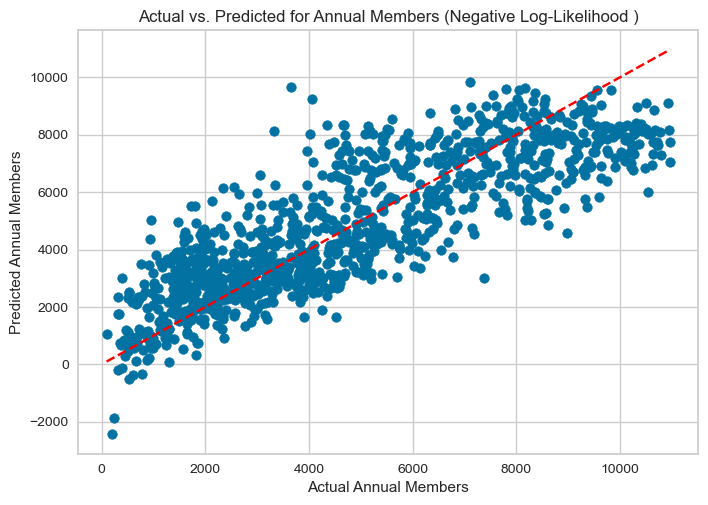

In [76]:
# Plotting actual vs. predicted for annual members
plt.scatter(y_annual, predicted_values_annual)
plt.plot([min(y_annual), max(y_annual)], [min(y_annual), max(y_annual)], linestyle='--', color='red')  # Identity line
plt.title('Actual vs. Predicted for Annual Members (Negative Log-Likelihood )')
plt.xlabel('Actual Annual Members')
plt.ylabel('Predicted Annual Members')
plt.show()

In [77]:
# Similarly, apply regression for casual memmber 
X_casual = df_18_20_days[['max_temp', 'min_temp', 'dew_pt_max', 'dew_pt_min', 'min_visbility', 'min_wind_chill',
               'weather_type_clear', 'weather_type_rain', 'weather_type_snow', 'Holiday', 'Weekend']]
y_casual = df_18_20_days['casual_members']

X_casual = sm.add_constant(X_casual)

model_casual = sm.OLS(y_casual, np.asarray(X_casual, dtype=float)).fit()

print(model_casual.summary())


                            OLS Regression Results                            
Dep. Variable:         casual_members   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     113.2
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          1.08e-160
Time:                        12:13:08   Log-Likelihood:                -9537.4
No. Observations:                1096   AIC:                         1.910e+04
Df Residuals:                    1085   BIC:                         1.915e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -474.3109    124.087     -3.822      0.0

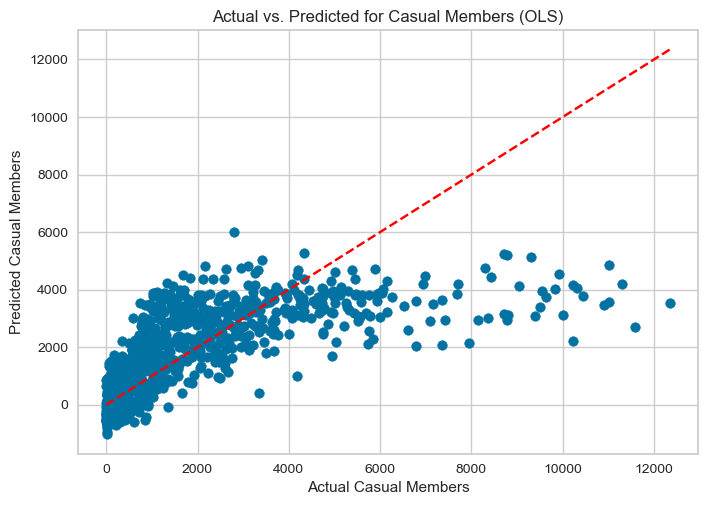

In [78]:
predicted_values_casual = model_casual.predict(X_casual)

# Plotting actual vs. predicted for casual members
plt.scatter(y_casual, predicted_values_casual)
plt.plot([min(y_casual), max(y_casual)], [min(y_casual), max(y_casual)], linestyle='--', color='red')  # Identity line
plt.title('Actual vs. Predicted for Casual Members (OLS)')
plt.xlabel('Actual Casual Members')
plt.ylabel('Predicted Casual Members')
plt.show()


In [79]:
#Convert the boolean columns to numeric (0 or 1) using the astype method in pandas.
X_casual['weather_type_clear'] = X_casual['weather_type_clear'].astype(int)
X_casual['weather_type_rain'] = X_casual['weather_type_rain'].astype(int)
X_casual['weather_type_snow'] = X_casual['weather_type_snow'].astype(int)


Looking at the kurtosis and skewness of casual member distribution, it is not normally distributed. 
If the assumption of normality for the residuals in a linear regression model is violated, and I suspect that the distribution of the residuals may follow a different shape. Therefore I consider using Robust Regression.

Robust Regression:
Robust regression methods are designed to be less sensitive to outliers and distributional assumptions. One common approach is to use the Huber loss or Tukey's biweight loss instead of the squared loss function used in ordinary least squares (OLS). This helps the model be less influenced by extreme observations.

In [80]:
# Assuming X_casual and y_casual are numeric and do not contain missing values
X_casual_numeric = X_casual.select_dtypes(include=[np.number])
model_casual_robust = sm.RLM(y_casual, sm.add_constant(X_casual_numeric), M=sm.robust.norms.HuberT()).fit()
print(model_casual_robust.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:         casual_members   No. Observations:                 1096
Model:                            RLM   Df Residuals:                     1085
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 10 Dec 2023                                         
Time:                        12:13:08                                         
No. Iterations:                    19                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -279.1743     63

Residual Analysis:

Examine the residuals (the differences between observed and predicted values).
Plot the residuals against the predicted values or the independent variables to check for patterns or heteroscedasticity.

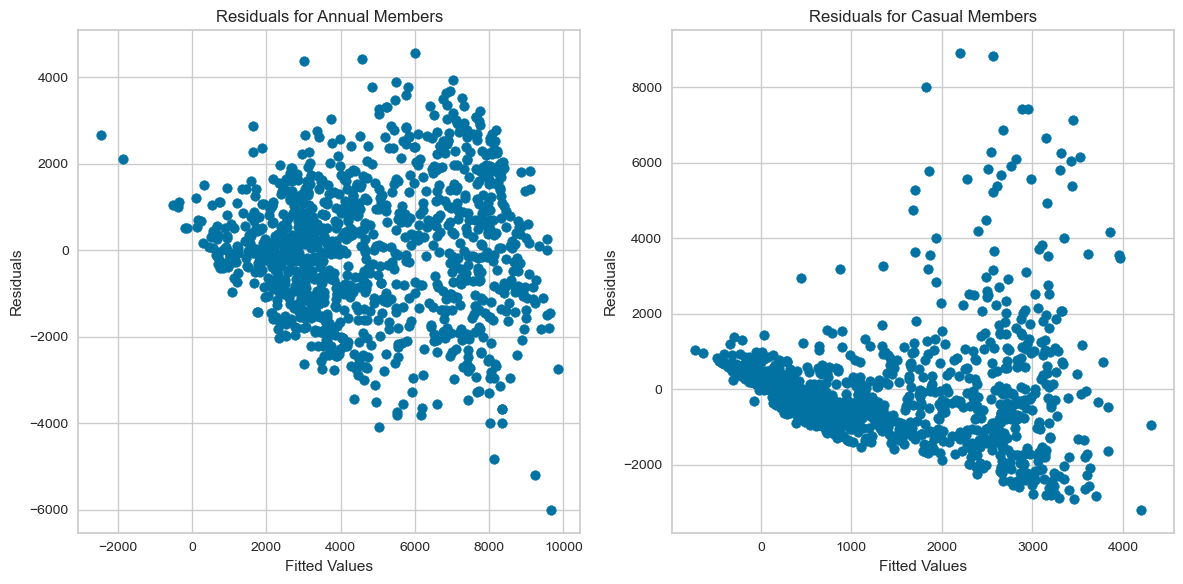

In [81]:
# Residuals for annual members
residuals_annual = model_annual.resid

# Residuals for casual members
residuals_casual = model_casual.resid

# Plotting residuals for annual members
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(model_annual.fittedvalues, residuals_annual)
plt.title('Residuals for Annual Members')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

# Plotting residuals for casual members
plt.subplot(1, 2, 2)
plt.scatter(model_casual_robust.fittedvalues, residuals_casual)
plt.title('Residuals for Casual Members')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


In [82]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming X_casual and y_casual are your independent and dependent variables
X_casual = df_18_20_days[['max_temp', 'min_temp', 'dew_pt_max', 'dew_pt_min', 'min_visbility', 'min_wind_chill',
                           'weather_type_clear', 'weather_type_rain', 'weather_type_snow', 'Holiday', 'Weekend']]
y_casual = df_18_20_days['casual_members']

# Polynomial Regression
degree = 5  
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_casual)

# Add a constant term to the independent variables matrix
X_poly = sm.add_constant(X_poly)

# Fit the regression model
model_casual_poly = sm.OLS(y_casual, X_poly).fit()

# Print the summary of the regression
print(model_casual_poly.summary())

                            OLS Regression Results                            
Dep. Variable:         casual_members   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     1.862
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.15e-09
Time:                        12:13:13   Log-Likelihood:                -8905.5
No. Observations:                1096   AIC:                         1.945e+04
Df Residuals:                     278   BIC:                         2.354e+04
Df Model:                         817                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8069.1520   5481.551     -1.472      0.1

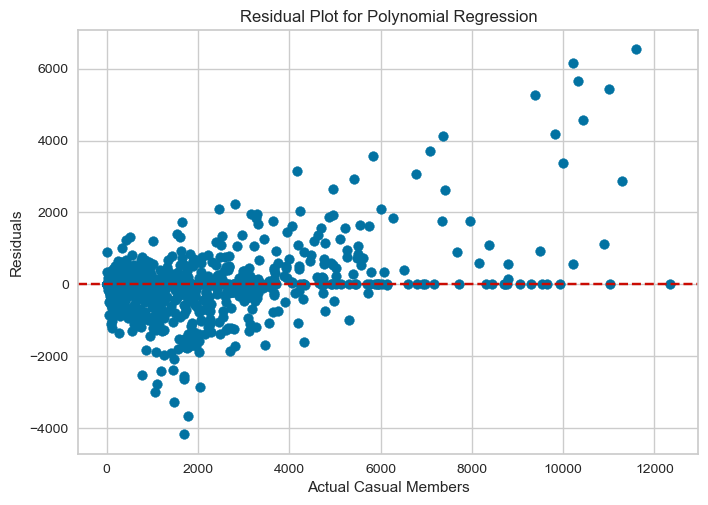

In [83]:
# Calculate residuals
residuals = model_casual_poly.resid

# Plot residuals
plt.scatter(y_casual, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Casual Members')
plt.ylabel('Residuals')
plt.title('Residual Plot for Polynomial Regression')
plt.show()

Heteroscedasticity means that the variability of the residuals is not constant across all levels of the independent variable(s). In other words, the spread of the residuals changes for different values of the predictor variables.

### Notes for Regression Model Interpretation:

Dependent variable:In this 2 regression analysis, the # of annual members/causal members are our dependent variable because we want to analyse the effect of 'max_temp', 'min_temp', 'dew_pt_max', 'dew_pt_min', 'min_visbility', 'min_wind_chill',
'weather_type_clear', 'weather_type_rain', 'weather_type_snow', 'Holiday', 'Weekend' on annual member ridership.

Model: The method of Ordinary Least Squares(OLS) is most widely used model due to its efficiency. This model gives best approximate of true population regression line. The principle of OLS is to minimize the square of errors ( ∑ei2 ).

Number of observations: The number of observation is the size of the sample, i.e. N = 1096
Degree of freedom is the number of independent observations on the basis of which the sum of squares is calculated.

D.f Residuals = 1096 – 11 = 1085
Degree of freedom(D.f) = N – K = 11-1=10

t – statistics are calculated by assuming  following hypothesis – 

    H0  : B2  = 0       ( variable X has no influence on Y)
    Ha  : B2  ≠ 0      (X has significant impact on Y)


p – values: 

In theory, we read that p-value is the probability of obtaining the t statistics at least as contradictory to H0  as calculated from assuming that the null hypothesis is true. In the summary table, we can see that P-value for both parameters is equal to 0. This is not exactly 0, but since we have very larger statistics (-12.458 and 17.296) p-value will be approximately 0.

If you know about significance levels then you can see that we can reject the null hypothesis at almost every significance level.

Confidence intervals:

There are many approaches to test the hypothesis, including the p-value approach mentioned above. The confidence interval approach is one of them. 5% is the standard significance level (∝) at which C.I’s are made. 

C.I for B1 is ( b1 – t∝/2 s.e(b1) , b1 + t∝/2 s.e(b1) )

Since ∝ = 5 %, b1 = -3.2002, s.e(b1) =0.257 , from t table , t0.025,148 = 1.655,

After putting values the C.I for B1 is approx. ( -3.708 , -2.693 ). Same can be done for b2 as well.

While calculating p values we rejected the null hypothesis we can see same in C.I as well. Since 0 does not lie in any of the intervals so we will reject the null hypothesis. 

 R – squared value: 

R2 is the coefficient of determination that tells us that how much percentage variation independent variable can be explained by independent variable. Here, 66.9 % variation in Y can be explained by X. The maximum possible value of R2  can be 1, means the larger the R2  value better the regression.

F – statistic: 
    
F test tells the goodness of fit of a regression. Inserting the values of R2, n and k, F = (0.669/1) / (0.331/148) = 229.12.
You can calculate the probability of F >229.1 for 1 and 148 df, which comes to approx. 0. From this, we again reject the null hypothesis stated above. 

The remaining terms are not often used. Terms like Skewness and Kurtosis tells about the distribution of data. Skewness and kurtosis for the normal distribution are 0 and 3 respectively. Jarque-Bera test is used for checking whether an error has normal distribution or not.  